In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.utils.data as data
from tqdm.auto import tqdm
from models import lenet5Conv
from models import lenet5Deconv
import prepare_data

In [2]:
# training data
train_img_filepath = 'DATA/MNSIT/train-images.idx3-ubyte'
train_label_filepath = 'DATA/MNSIT/train-labels.idx1-ubyte'

# testing data
test_img_filepath = 'DATA/MNSIT/t10k-images.idx3-ubyte'
test_label_filepath = 'DATA/MNSIT/t10k-labels.idx1-ubyte'


In [3]:
# batch size of 64
BATCH_SIZE = 64

train_loader, test_loader = prepare_data.load(train_img_filepath, 
                                            train_label_filepath, 
                                            test_img_filepath,
                                            test_label_filepath, 
                                            BATCH_SIZE
                                        )
        

In [4]:
# setting the device on which PyTorch trains to CPU; Can set it to GPU is GPU is available
device = 'cpu'

In [5]:
# Defining accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc
    
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send training data to CPU or GPU
        X = X.to(torch.float32)
        X, y = X.to(device), y.to(device)
        # Forward pass
        # X = torch.unsqueeze(X,-1)
        # print(X.shape)
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # logits to prediction label

        # Grad of optimizer to zero (optimization the weights)
        optimizer.zero_grad()

        # Update the weights by backpropagation
        loss.backward()
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss.detach().to('cpu').numpy(), train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in evaluation mode

    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send testing data to CPU or GPU
            X = X.to(torch.float32)
            X, y = X.to(device), y.to(device)
            # X = torch.unsqueeze(X,0)
            # Forward pass
            test_pred = model(X)
            
            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # logits to prediction label
            )
        
    
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss.detach().to('cpu').numpy(), test_acc


In [6]:
torch.manual_seed(42)
model = lenet5Conv(1, [6, 16], 10)
model.to(device)
model

lenet5Conv(
  (first_conv2d): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (first_sigmoid): Sigmoid()
  (first_maxPool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (second_conv2d): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (second_sigmoid): Sigmoid()
  (second_maxPool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=84, out_features=10, bias=True)
    (6): LogSoftmax(dim=1)
  )
)

In [7]:
# Cross entropy loss
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.NLLLoss()

# Adam optimizer with learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
EPOCHS = 20

train_plot = []
test_plot = []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_loader, 
        model=model, 
        loss_fn=loss_function,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    
    train_plot.append((train_acc, train_loss))

    test_loss, test_acc = test_step(data_loader=test_loader,
        model=model,
        loss_fn=loss_function,
        accuracy_fn=accuracy_fn
    )
    test_plot.append((test_acc, test_loss))
    

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.04684 | Train accuracy: 65.75%
Test loss: 0.27267 | Test accuracy: 92.51%

Epoch: 1
---------
Train loss: 0.19443 | Train accuracy: 94.44%
Test loss: 0.11991 | Test accuracy: 96.38%

Epoch: 2
---------
Train loss: 0.11628 | Train accuracy: 96.50%
Test loss: 0.08222 | Test accuracy: 97.60%

Epoch: 3
---------
Train loss: 0.08902 | Train accuracy: 97.33%
Test loss: 0.07586 | Test accuracy: 97.67%

Epoch: 4
---------
Train loss: 0.07284 | Train accuracy: 97.78%
Test loss: 0.06582 | Test accuracy: 97.90%

Epoch: 5
---------
Train loss: 0.06159 | Train accuracy: 98.12%
Test loss: 0.05208 | Test accuracy: 98.43%

Epoch: 6
---------
Train loss: 0.05449 | Train accuracy: 98.32%
Test loss: 0.04762 | Test accuracy: 98.54%

Epoch: 7
---------
Train loss: 0.04693 | Train accuracy: 98.54%
Test loss: 0.05036 | Test accuracy: 98.31%

Epoch: 8
---------
Train loss: 0.04155 | Train accuracy: 98.74%
Test loss: 0.04252 | Test accuracy: 98.69%

Epoch: 9
---------
Train los

Text(0, 0.5, 'Accuracy %')

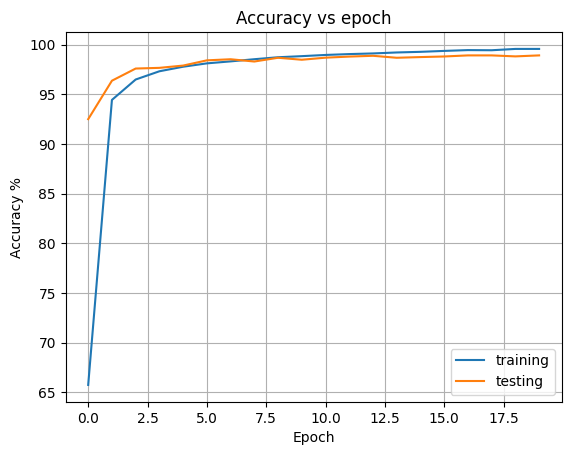

In [11]:
plt.plot([i[0] for i in train_plot], label='training')
plt.plot([i[0] for i in test_plot], label='testing')
plt.grid()
plt.legend()
plt.title('Accuracy vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')

Text(0, 0.5, 'Loss')

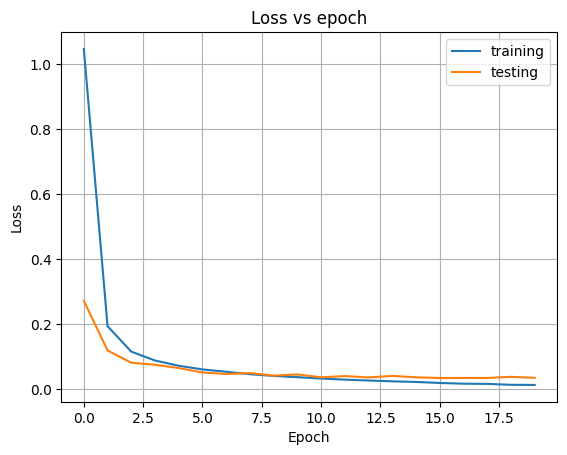

In [12]:
plt.plot([i[1] for i in train_plot], label='training')
plt.plot([i[1] for i in test_plot], label='testing')
plt.grid()
plt.legend()
plt.title('Loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [15]:
class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        self._features = dict()

        layers = dict([*self.model.named_modules()])
        for layer_id, layer in layers.items():
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str):
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x):
        self.model.eval()
        _ = self.model(x)
        return self._features

In [16]:
test_batch_features, test_batch_lables = next(iter(test_loader))
test_batch_features.shape

torch.Size([64, 1, 28, 28])

In [17]:
test_input = test_batch_features[0]
test_input = torch.unsqueeze(test_input,0)
test_input = test_input.to(torch.float32)

In [68]:
model_features = FeatureExtractor(model)
features = model_features(test_input)

In [31]:
torch.max(features['first_conv2d'][0,1,:, :]).item()

7.382544040679932

In [20]:
features.keys()

dict_keys(['first_conv2d', 'first_sigmoid', 'first_maxPool2d', 'second_conv2d', 'second_sigmoid', 'second_maxPool2d', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6', 'classifier', ''])

In [71]:
layer = 'second_conv2d'
num_feat = features[layer].shape[1]
new_feat_map = features[layer].clone()
# choose the max activations map
act_lst = []
for i in range(0, num_feat):
    choose_map = new_feat_map[0, i, :, :]
    activation = torch.max(choose_map)
    act_lst.append(activation.item())

act_lst = np.array(act_lst)
mark = np.argmax(act_lst)

choose_map = new_feat_map[0, mark, :, :].clone()
new_feat_map[:,:,:,:] = 0
new_feat_map[0,mark, :, :] = choose_map
max_activation = torch.max(choose_map)

In [76]:
model_deconv = lenet5Deconv([6, 16])

In [121]:
model_deconv.eval()
switch = {'first_maxPool2d': features['first_maxPool2d'][1], 'second_maxPool2d':features['second_maxPool2d'][1] }
new_img = model_deconv(new_feat_map, 2, switch)

In [122]:
new_img = torch.squeeze(new_img, 1)
new_img = torch.squeeze(new_img, 0)

In [123]:
new_img = new_img.data.numpy()

In [112]:
new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
new_img = new_img.astype(np.uint8)

In [125]:
new_img

array([[ 0.39354917, -0.10198262,  0.14110681,  0.1190325 ,  0.16187546,
         0.06309074,  0.17951971,  0.09098005,  0.22696841,  0.08998677,
         0.22631899,  0.08965015,  0.2214678 ,  0.0916591 ,  0.21845958,
         0.07919118,  0.2069791 ,  0.07373202,  0.20581892,  0.04412359,
         0.1571204 ,  0.12805161,  0.14814675,  0.0942969 ,  0.1354278 ,
         0.1394318 ,  0.01983134, -0.42782438],
       [ 0.5106236 ,  0.06706807,  0.39172223,  0.33858815,  0.36816707,
         0.347389  ,  0.3177109 ,  0.34347525,  0.3209604 ,  0.31224343,
         0.31899223,  0.30221528,  0.32412156,  0.28701866,  0.32699516,
         0.27166086,  0.31998888,  0.26951128,  0.30526742,  0.2548993 ,
         0.31816298,  0.3127881 ,  0.35589263,  0.2979452 ,  0.39371684,
         0.27754056,  0.06930858, -0.5312199 ],
       [ 0.42928836, -0.07419255,  0.17661268,  0.24840635,  0.19158873,
         0.22067735,  0.16679966,  0.2124674 ,  0.17341378,  0.21300456,
         0.19011354,  0.1755

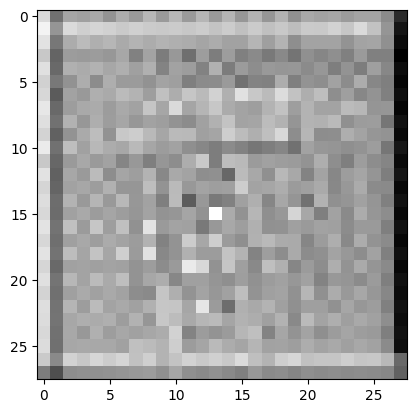

In [124]:
plt.imshow(new_img, cmap='gray')

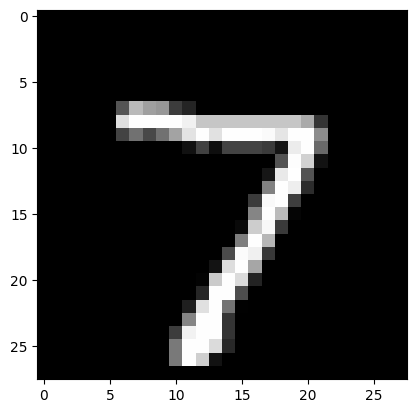

In [120]:
plt.imshow(test_input[0][0], cmap='gray')